In [1]:
import pandas as pd
import numpy as np

treino = pd.read_csv('merged_treinofinal.csv')
# treino = pd.read_csv('TH.csv')

In [8]:
#treino.columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

for c in treino.columns:
    print(f'{c} -> {treino[c].isna().sum()}')

Jornada -> 0
Dia -> 0
Data -> 0
Horário -> 0
home -> 0
xG_home -> 0
xG_away -> 0
away -> 0
Assistance -> 0
Local -> 0
Árbitro -> 0
Relatório da Partida -> 0
goals_home -> 0
goals_away -> 0
formacao_home -> 0
formacao_away -> 0
Faltas_home -> 0
Faltas_away -> 0
Escanteios_home -> 0
Escanteios_away -> 0
Cruzamentos_home -> 0
Cruzamentos_away -> 0
Contatos_home -> 0
Contatos_away -> 0
Bote defensivo_home -> 0
Bote defensivo_away -> 0
Cortes_home -> 0
Cortes_away -> 0
Defesas_home -> 0
Defesas_away -> 0
Impedimentos_home -> 0
Impedimentos_away -> 0
Tiro de meta_home -> 67
Tiro de meta_away -> 67
Bolas longas_home -> 0
Bolas longas_away -> 0
yellow_card_home -> 0
red_card_home -> 0
yellow_red_card_home -> 0
yellow_card_away -> 0
red_card_away -> 0
yellow_red_card_away -> 0
jogador1_home -> 1
jogador2_home -> 1
jogador3_home -> 1
jogador4_home -> 1
jogador5_home -> 1
jogador6_home -> 1
jogador7_home -> 1
jogador8_home -> 1
jogador9_home -> 1
jogador10_home -> 1
jogador11_home -> 1
jogador12_

In [2]:
treino['Data'] = pd.to_datetime(treino['Data']).dt.date

In [7]:
import datetime
#Horário de verão ou inverno
treino['Horario'] = 1

treino.loc[treino['Data'] < datetime.date(2023,3,26), 'Horario'] = 0
treino.loc[treino['Data'] < datetime.date(2022,10,30), 'Horario'] = 1
treino.loc[treino['Data'] < datetime.date(2022,3,27), 'Horario'] = 0
treino.loc[treino['Data'] < datetime.date(2021,10,31), 'Horario'] = 1
treino.loc[treino['Data'] < datetime.date(2021,3,28), 'Horario'] = 0
treino.loc[treino['Data'] < datetime.date(2020,10,25), 'Horario'] = 1
treino.loc[treino['Data'] < datetime.date(2020,3,29), 'Horario'] = 0
treino.loc[treino['Data'] < datetime.date(2019,10,27), 'Horario'] = 1
treino.loc[treino['Data'] < datetime.date(2019,3,31), 'Horario'] = 0
treino.loc[treino['Data'] < datetime.date(2018,10,28), 'Horario'] = 1

treino['hora_noite'] = pd.to_datetime(treino['hora_noite'])
treino.loc[treino['Horario'] == 1, 'hora_noite'] = treino.loc[treino['Horario'] == 1, 'hora_noite'] + pd.Timedelta(hours=1)
treino['hora_noite'] = treino['hora_noite'].dt.time

treino['Horário'] = pd.to_datetime(treino['Horário']).dt.time
treino['Noite'] = treino['Horário'] > treino['hora_noite']

In [8]:
treino['Noite'].value_counts()

False    923
True     301
Name: Noite, dtype: int64

In [9]:
treino['dif'] = treino['goals_home'] - treino['goals_away']
treino['xg_dif'] = treino['xG_home'] - treino['xG_away']

treino.loc[treino['dif']>0, 'result'] = 'H'
treino.loc[treino['dif']==0, 'result'] = 'D'
treino.loc[treino['dif']<0, 'result'] = 'A'

In [10]:
#Define o favorito
treino.loc[treino['B365H'] < 2.26, 'fav'] = 'H'
treino.loc[treino['B365H'] < 1.40, 'fav'] = 'HH'
treino.loc[treino['B365A'] < 2.26, 'fav'] = 'A'
treino.loc[treino['B365A'] < 1.40, 'fav'] = 'AA'
treino.loc[treino['fav'].isna(), 'fav'] = 'D'

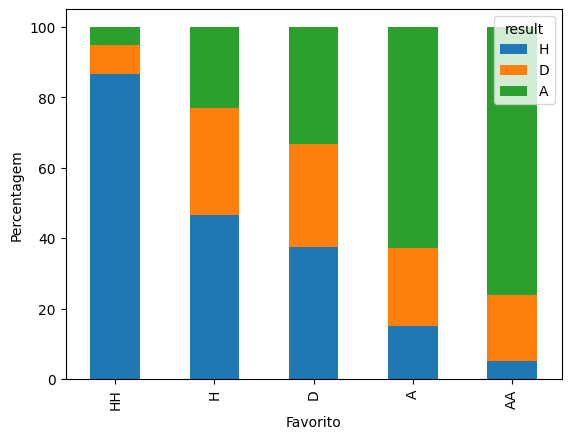

In [8]:
import matplotlib.pyplot as plt
order = ['H', 'D', 'A']
category_order = ['HH', 'H', 'D', 'A', 'AA']

# Convert 'x' column to categorical data type with the specified order
treino['fav'] = pd.Categorical(treino['fav'], categories=category_order, ordered=True)
treino['result'] = pd.Categorical(treino['result'], categories=order, ordered=True)

# Calculate the percentage of values in column 'y' for each unique value in column 'x'
result = treino.groupby('fav')['result'].value_counts(normalize=True) * 100

# Criar o gráfico de barras
result.unstack().plot(kind='bar',stacked=True)

# Configurar os rótulos dos eixos
plt.xlabel('Favorito')
plt.ylabel('Percentagem')

# Exibir o gráfico
plt.show()

<AxesSubplot: ylabel='fav'>

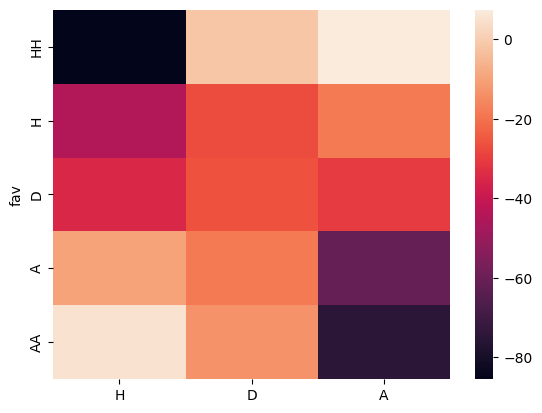

In [9]:
import seaborn as sns
#Fazer reverse ao cmap

order = ['H', 'D', 'A']

sns.heatmap(treino[['fav','B365H','B365D','B365A']].groupby('fav').mean().rename({'B365H': 'H','B365D': 'D', 'B365A': 'A'}, axis=1) - result.unstack()[order].reindex(['HH', 'H', 'D', 'A', 'AA']))

In [10]:
treino[['Horário','result']].groupby('Horário').count()

,result
Horário,
12:45:00,1
13:00:00,1
14:00:00,3
14:30:00,13
15:00:00,110
15:30:00,141
16:00:00,28
16:30:00,15
17:00:00,41


In [4]:
import requests

datas = treino['Data'].unique()

for data in datas:
    url = f'https://api.sunrise-sunset.org/json?lat=41.4500&lng=-8.3000&date={data}'
    response = requests.get(url)
    resposta = response.json()
    treino.loc[treino['Data'] == data, 'hora_noite'] = resposta['results']['astronomical_twilight_end']
    print(data)


2018-08-10
2018-08-11
2018-08-12
2018-08-13
2018-08-17
2018-08-18
2018-08-19
2018-08-20
2018-08-24
2018-08-25
2018-08-26
2018-08-27
2018-08-31
2018-09-01
2018-09-02
2018-09-21
2018-09-22
2018-09-23
2018-09-24
2018-09-27
2018-09-28
2018-09-29
2018-09-30
2018-10-01
2018-10-05
2018-10-06
2018-10-07
2018-10-26
2018-10-27
2018-10-28
2018-11-02
2018-11-03
2018-11-04
2018-11-05
2018-11-09
2018-11-10
2018-11-11
2018-11-30
2018-12-01
2018-12-02
2018-12-03
2018-12-07
2018-12-08
2018-12-09
2018-12-10
2018-12-14
2018-12-15
2018-12-16
2018-12-22
2018-12-23
2019-01-02
2019-01-03
2019-01-05
2019-01-06
2019-01-07
2019-01-10
2019-01-11
2019-01-12
2019-01-13
2019-01-18
2019-01-19
2019-01-20
2019-01-28
2019-01-29
2019-01-30
2019-02-01
2019-02-02
2019-02-03
2019-02-04
2019-02-08
2019-02-09
2019-02-10
2019-02-11
2019-02-15
2019-02-16
2019-02-17
2019-02-18
2019-02-22
2019-02-23
2019-02-24
2019-02-25
2019-03-01
2019-03-02
2019-03-03
2019-03-04
2019-03-08
2019-03-09
2019-03-10
2019-03-11
2019-03-15
2019-03-16

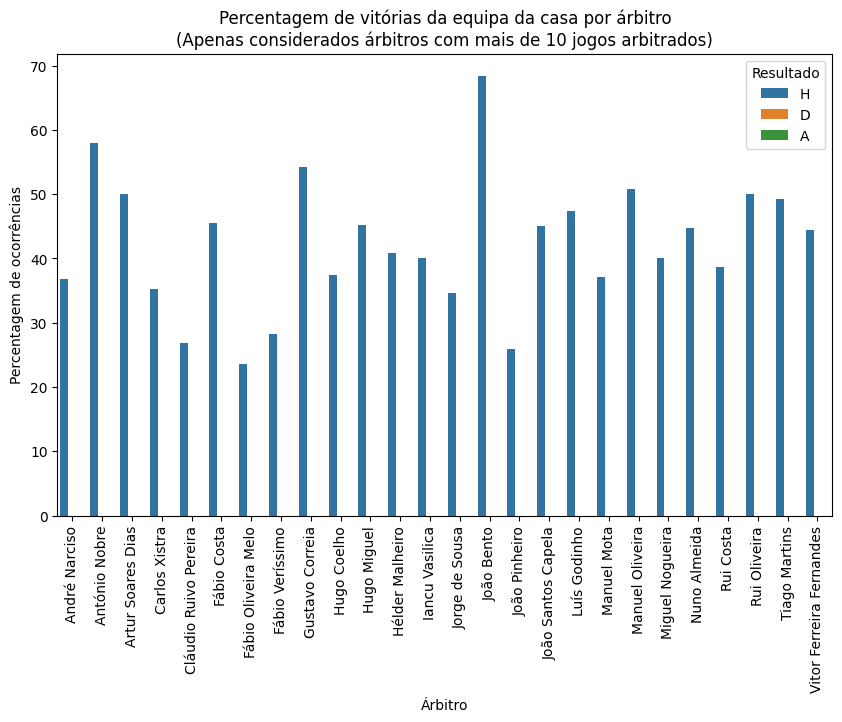

In [11]:
import matplotlib.pyplot as plt

# Calcular a contagem de ocorrências de cada valor por árbitro
# Contar o número de jogos arbitrados por árbitro
counts_arbitro = treino['Árbitro'].value_counts()

# Filtrar os árbitros com menos de 10 jogos arbitrados
arbitros_filtrados = counts_arbitro[counts_arbitro >= 10].index

# Filtrar o DataFrame original com base nos árbitros filtrados
df_filtrado = treino[treino['Árbitro'].isin(arbitros_filtrados)]

# Calcular a contagem de ocorrências de cada valor por árbitro no DataFrame filtrado
counts = df_filtrado.groupby('Árbitro')['result'].value_counts(normalize=True).mul(100).rename('Percentage').reset_index()

counts = counts[counts['result'] == 'H']

# Criar o gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x='Árbitro', y='Percentage', hue='result', data=counts)
plt.title('Percentagem de vitórias da equipa da casa por árbitro\n(Apenas considerados árbitros com mais de 10 jogos arbitrados)')
plt.xlabel('Árbitro')
plt.ylabel('Percentagem de ocorrências')
plt.xticks(rotation=90)
plt.legend(title='Resultado')

plt.show()

Shapiro-Wilk p-value:  6.636236789580201e-18


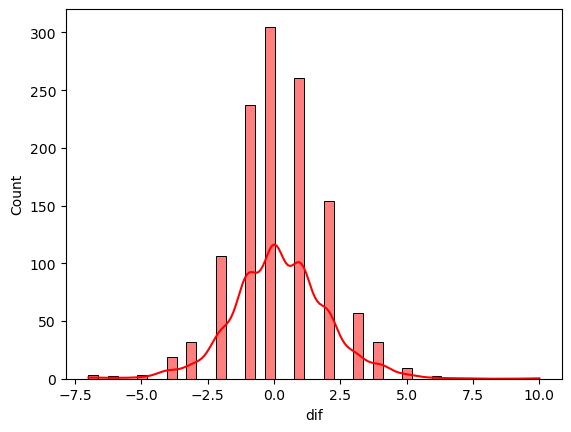

In [11]:
from scipy.stats import shapiro
import seaborn as sns

sns.histplot(data=treino, x='dif', color='red', kde=True)
_, p_value = shapiro(treino['dif'])
print("Shapiro-Wilk p-value: ", p_value)

# Shapiro-Wilk p-value:  6.636236789580201e-18 
# We reject the normality

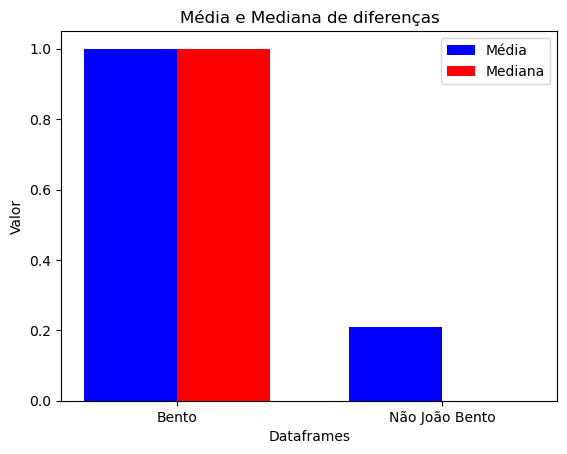

In [30]:

# Calculate the mean and median for 'bento'
media_bento = bento['dif'].mean()
mediana_bento = bento['dif'].median()

# Calculate the mean and median for 'nao_bento'
media_nao_bento = nao_bento['dif'].mean()
mediana_nao_bento = nao_bento['dif'].median()

# Create a bar plot
labels = ['Bento', 'Não João Bento']
media_values = [media_bento, media_nao_bento]
mediana_values = [mediana_bento, mediana_nao_bento]

# Set the bar width
bar_width = 0.35

# Set the positions of the bars on the x-axis
bar_positions = np.arange(len(labels))

# Create the figure and axes
fig, ax = plt.subplots()

# Plot the mean bars
ax.bar(bar_positions, media_values, bar_width, color='blue', label='Média')

# Plot the median bars with a slight shift in position
ax.bar(bar_positions + bar_width, mediana_values, bar_width, color='red', label='Mediana')

# Add labels and title to the plot
ax.set_xlabel('Dataframes')
ax.set_ylabel('Valor')
ax.set_title('Média e Mediana de diferenças')

# Set the x-axis tick labels
ax.set_xticks(bar_positions + bar_width / 2)
ax.set_xticklabels(labels)

# Add a legend
ax.legend()

# Display the plot
plt.show()

In [29]:
nao_bento['dif'].median()

0.0

In [19]:


from scipy.stats import mannwhitneyu
# Testar se há evidência estatística de que a presença do árbitro João Bento influencia a favor da equipa da casa

bento = treino[treino['Árbitro'] == 'João Bento']
nao_bento = treino[treino['Árbitro'] != 'João Bento']

# -> H0: média da dif de golos com joão bento - média da dif de golos sem joão bento = 0 (A equipa da casa não tem vantagem)
# -> H1: média da dif de golos com joão bento - média da dif de golos sem joão bento > 0 (A equipa da casa tem vantagem)

test_statistic, p_value = mannwhitneyu(bento['dif'], nao_bento['dif'], alternative='greater')

# Print the test statistic and p-value
print("t-test statistic: {:.2f}".format(test_statistic))
print("p-value: {:.4f}".format(p_value))

# t-test statistic: 1.93
# p-value: 0.0269

# Como p-value < 0.05, rejeitamos H0, o que nos diz que a equipa da casa é beneficiada com a presença do árbitro João Bento

# Nota: Este árbitro foi despromovido na época 2020/21

t-test statistic: 14757.50
p-value: 0.0138


In [13]:
# Testar se há evidência estatística de que a presença do árbitro António Nobre influencia a favor da equipa da casa

bento = treino[treino['Árbitro'] == 'António Nobre']
nao_bento = treino[treino['Árbitro'] != 'António Nobre']

# -> H0: média da dif de golos com joão bento - média da dif de golos sem joão bento = 0 (A equipa da casa não tem vantagem)
# -> H1: média da dif de golos com joão bento - média da dif de golos sem joão bento > 0 (A equipa da casa tem vantagem)

test_statistic, p_value = mannwhitneyu(bento['dif'], nao_bento['dif'], alternative='greater')

# Print the test statistic and p-value
print("t-test statistic: {:.2f}".format(test_statistic))
print("p-value: {:.4f}".format(p_value))

# t-test statistic: 2.60
# p-value: 0.0034

# Como p-value < 0.05, rejeitamos H0, o que nos diz que a equipa da casa é beneficiada com a presença do árbitro João Bento

t-test statistic: 35869.50
p-value: 0.0034


In [14]:
treino[treino['Árbitro'] == 'António Nobre']['dif'].mean()

0.86

In [15]:
treino[treino['Árbitro'] != 'António Nobre']['dif'].mean()

0.19591141396933562

<AxesSubplot: xlabel='Assistance'>

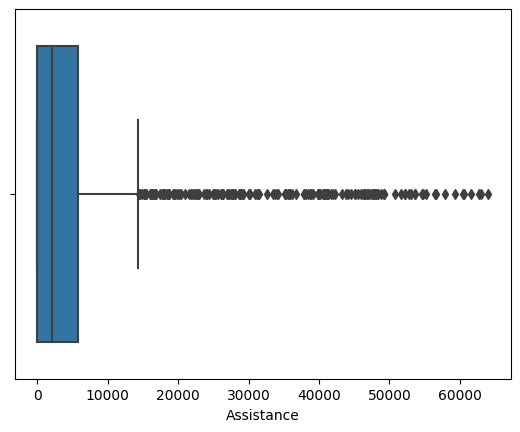

In [16]:
import seaborn as sns

sns.boxplot(x=treino['Assistance'])

Shapiro-Wilk p-value:  0.0


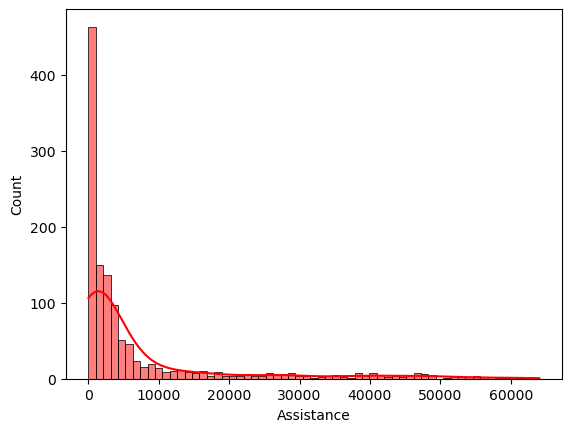

In [14]:
sns.histplot(data=treino, x='Assistance', color='red', kde=True)
_, p_value = shapiro(treino['Assistance'])
print("Shapiro-Wilk p-value: ", p_value)

# Shapiro-Wilk p-value:  6.636236789580201e-18 
# We reject the normality

Text(0.5, 1.0, 'Distribution of Attendance and Poisson Distribution')

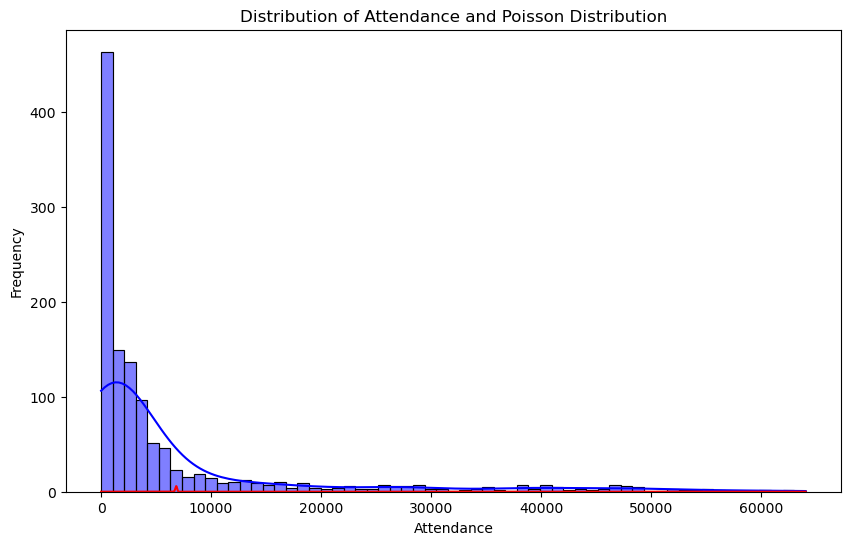

In [18]:
from scipy.stats import poisson
import matplotlib.pyplot as plt

attendance = treino['Assistance']

lambda_est = attendance.mean()

# Generate the x-values (range of attendance)
x = np.arange(0, max(attendance) + 1)

# Calculate the probabilities of the Poisson distribution
poisson_probs = poisson.pmf(x, lambda_est)

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the histogram of attendance
sns.histplot(data=attendance, ax=ax, kde=True, color='blue', label='Attendance')

# Plot the Poisson distribution
ax.plot(x, poisson_probs * len(attendance), color='red', label='Poisson Distribution')

# Set the plot labels and title
ax.set_xlabel('Attendance')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Attendance and Poisson Distribution')

In [17]:
treino['Assistance'].describe()

count     1224.000000
mean      6826.734477
std      12284.294068
min          0.000000
25%          0.000000
50%       2101.500000
75%       5704.250000
max      64064.000000
Name: Assistance, dtype: float64

In [18]:
treino['dif'] = treino['goals_home'] - treino['goals_away']
treino['xg_dif'] = treino['xG_home'] - treino['xG_away']

treino_t1 = treino[['Data','Assistance','dif','xg_dif']].copy()

covid = treino_t1[treino_t1['Assistance'] == 0]
nao_covid = treino_t1[treino_t1['Assistance'] != 0]

In [19]:
# -> H0: média da dif de golos com espectadores - média da dif de golos sem espectadores = 0
# -> H1: média da dif de golos com espectadores - média da dif de golos sem espectadores > 0
from scipy.stats import ttest_ind

test_statistic, p_value = ttest_ind(covid['dif'], nao_covid['dif'], alternative='greater')

# Print the test statistic and p-value
print("t-test statistic: {:.2f}".format(test_statistic))
print("p-value: {:.4f}".format(p_value))

# t-test statistic: -0.72
# p-value: 0.7645

# Não rejeitamos a hipotese nula, a presença de espectadores não afeta a diferença de golos

t-test statistic: -0.72
p-value: 0.7645


In [20]:
# -> H0: média da dif de golos com espectadores - média da dif de golos sem espectadores = 0
# -> H1: média da dif de golos com espectadores - média da dif de golos sem espectadores > 0
from scipy.stats import ttest_ind


test_statistic, p_value = ttest_ind(covid['xg_dif'], nao_covid['xg_dif'], alternative='greater')

# Print the test statistic and p-value
print("t-test statistic: {:.2f}".format(test_statistic))
print("p-value: {:.4f}".format(p_value))

# t-test statistic: -0.67
# p-value: 0.7472

# Não rejeitamos a hipotese nula

t-test statistic: -0.67
p-value: 0.7472


In [21]:
treino.loc[treino['Dia'] == 'sáb', 'FDSem'] = 1
treino.loc[treino['Dia'] == 'dom', 'FDSem'] = 1
treino.loc[treino['FDSem'].isna(), 'FDSem'] = 0

In [22]:
treino['Noite'].value_counts()

False    923
True     301
Name: Noite, dtype: int64

In [23]:
fim = treino[treino['FDSem'] == 1]
nao_fim = treino[treino['FDSem'] != 1]

noite = treino[treino['Noite'] == True]
nao_noite = treino[treino['Noite'] == False]

In [24]:
# -> H0: média da dif de golos com jogo ao fim de semana
# -> H1: média da dif de golos com jogo durante a semana
from scipy.stats import ttest_ind


test_statistic, p_value = ttest_ind(fim['xg_dif'], nao_fim['xg_dif'], alternative='greater')

# Print the test statistic and p-value
print("t-test statistic: {:.2f}".format(test_statistic))
print("p-value: {:.4f}".format(p_value))

# t-test statistic: 1.46
# p-value: 0.0722

t-test statistic: 1.46
p-value: 0.0722


In [25]:
# -> H0: média da dif de golos com jogo à noite
# -> H1: média da dif de golos com jogo durante o dia
from scipy.stats import ttest_ind


test_statistic, p_value = ttest_ind(noite['xg_dif'], nao_noite['xg_dif'], alternative='greater')

# Print the test statistic and p-value
print("t-test statistic: {:.2f}".format(test_statistic))
print("p-value: {:.4f}".format(p_value))

# t-test statistic: -0.03
# p-value: 0.5101

t-test statistic: -0.03
p-value: 0.5101


In [26]:
treino['formacao_home'].value_counts()

4-2-3-1      318
4-3-3        282
4-4-2        248
3-4-3        177
4-1-4-1       79
5-4-1         29
4-4-1-1       18
3-4-1-2       16
3-5-2         15
5-3-2         13
4-5-1          7
4-1-2-1-2      6
4-1-3-2        5
4-2-2-2        3
4-3-1-2        3
3-2-4-1        1
4-3-2-1        1
3-5-1-1        1
4-4-0          1
3-1-4-2        1
Name: formacao_home, dtype: int64

In [27]:
treino['formacao_home'].isna().sum()

0

In [28]:
seis = treino[treino['AST'] >= 6]
nao_seis = treino[treino['AST'] < 6]



In [29]:
seis

,Jornada,Dia,Data,Horário,home,xG_home,xG_away,away,Assistance,Local,...,jogador20_away,jogador20_home,hora_noite,Horario,Noite,dif,xg_dif,result,fav,FDSem
7,1.0,dom,2018-08-12,20:30:00,Sp Braga,2.3,1.3,Nacional,12387.0,Estádio Municipal de Braga,...,NaN,NaN,22:23:51,1,False,2,1.0,H,HH,1.0
11,2.0,sáb,2018-08-18,19:00:00,Boavista,0.4,1.3,Benfica,15189.0,Estádio do Bessa Século XXI,...,NaN,NaN,22:12:25,1,False,-2,-0.9,A,A,1.0
14,2.0,dom,2018-08-19,16:00:00,Nacional,2.7,1.9,Moreirense,2491.0,Estádio da Madeira,...,NaN,NaN,22:10:29,1,False,-1,0.8,A,D,1.0
15,2.0,dom,2018-08-19,18:30:00,Belenenses,1.8,1.7,Porto,10901.0,Estádio Nacional,...,NaN,NaN,22:10:29,1,False,-1,0.1,A,AA,1.0
16,2.0,dom,2018-08-19,19:30:00,Santa Clara,1.0,0.6,Sp Braga,3915.0,Estádio de São Miguel,...,NaN,NaN,22:10:29,1,False,0,0.4,D,A,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1189,31.0,sáb,2022-04-23,15:30:00,Portimonense,1.2,0.9,Moreirense,990.0,Estádio do Portimonense SC,...,NaN,NaN,22:04:54,1,False,1,0.3,H,D,1.0
1201,32.0,sáb,2022-04-30,21:00:00,Belenenses,0.7,1.8,Sp Braga,1834.0,Estádio Nacional,...,NaN,NaN,22:15:54,1,False,-1,-1.1,A,A,1.0
1209,33.0,sáb,2022-05-07,20:30:00,Portimonense,0.8,3.3,Sp Lisbon,3903.0,Estádio do Portimonense SC,...,NaN,NaN,22:27:11,1,False,-1,-2.5,A,AA,1.0
1215,34.0,sex,2022-05-13,20:15:00,Pacos Ferreira,0.8,2.2,Benfica,5635.0,Estádio da Capital do Móvel,...,NaN,NaN,22:36:53,1,False,-2,-1.4,A,A,0.0


In [30]:
# -> H0: média da dif de golos com +6 remates à baliza - média da dif de golos com -6 remates à baliza = 0
# -> H1: média da dif de golos com +6 remates à baliza - média da dif de golos com -6 remates à baliza > 0
from scipy.stats import ttest_ind


test_statistic, p_value = ttest_ind(seis['dif'], nao_seis['dif'], alternative='greater')

# Print the test statistic and p-value
print("t-test statistic: {:.2f}".format(test_statistic))
print("p-value: {:.4f}".format(p_value))

# t-test statistic: -0.03
# p-value: 0.5101

# tenho de corrigir

t-test statistic: -13.72
p-value: 1.0000


In [31]:
treino.loc[treino['result'] == 'H', 'home_Points'] = 3
treino.loc[treino['result'] == 'D', 'home_Points'] = 1
treino.loc[treino['result'] == 'A', 'home_Points'] = 0
treino.loc[treino['result'] == 'A', 'away_Points'] = 3
treino.loc[treino['result'] == 'D', 'away_Points'] = 1
treino.loc[treino['result'] == 'H', 'away_Points'] = 0

for team in treino['home'].unique():
       dfHomeGames = treino[treino['home'] == team]
       dfAwayGames = treino[treino['away'] == team]
       dfTotal = pd.concat([dfHomeGames,dfAwayGames])

       dfTotal.sort_index(inplace=True)
       rows_to_update_home = dfHomeGames.index
       rows_to_update_away = dfAwayGames.index
       
       dfTotal['points'] = dfTotal.apply(lambda row: row['home_Points'] if row['home'] == team else row['away_Points'],axis=1)
       coluna = 'points'
       dfTotal[f'{coluna}_MA5'] = dfTotal[coluna].rolling(5, closed='left').mean()
       dfTotal[f'{coluna}_MA17'] = dfTotal[coluna].rolling(17, closed='left').mean()
       dfTotal[f'{coluna}_MA34'] = dfTotal[coluna].rolling(34, closed='left').mean()
       treino.loc[rows_to_update_home, f'{coluna}_home_MA5'] = dfTotal.loc[rows_to_update_home, f'{coluna}_MA5']
       treino.loc[rows_to_update_away, f'{coluna}_away_MA5'] = dfTotal.loc[rows_to_update_away, f'{coluna}_MA5']
       treino.loc[rows_to_update_home, f'{coluna}_home_MA17'] = dfTotal.loc[rows_to_update_home, f'{coluna}_MA17']
       treino.loc[rows_to_update_away, f'{coluna}_away_MA17'] = dfTotal.loc[rows_to_update_away, f'{coluna}_MA17']
       treino.loc[rows_to_update_home, f'{coluna}_home_MA34'] = dfTotal.loc[rows_to_update_home, f'{coluna}_MA34']
       treino.loc[rows_to_update_away, f'{coluna}_away_MA34'] = dfTotal.loc[rows_to_update_away, f'{coluna}_MA34']


In [32]:
treino

,Jornada,Dia,Data,Horário,home,xG_home,xG_away,away,Assistance,Local,...,fav,FDSem,home_Points,away_Points,points_home_MA5,points_away_MA5,points_home_MA17,points_away_MA17,points_home_MA34,points_away_MA34
0,1.0,sex,2018-08-10,20:30:00,Benfica,1.9,1.0,Guimaraes,55219.0,Estádio do Sport Lisboa e Benfica,...,HH,0.0,3.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,sáb,2018-08-11,16:30:00,Setubal,1.8,0.3,Aves,5182.0,Estádio do Bonfim,...,H,1.0,3.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,sáb,2018-08-11,19:00:00,Tondela,1.3,0.5,Belenenses,2010.0,Estádio João Cardoso,...,H,1.0,0.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,sáb,2018-08-11,21:00:00,Porto,4.5,0.1,Chaves,46509.0,Estádio Do Dragão,...,HH,1.0,3.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,dom,2018-08-12,16:00:00,Maritimo,2.2,0.8,Santa Clara,5893.0,Estádio dos Barreiros,...,H,1.0,3.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1219,34.0,sáb,2022-05-14,18:00:00,Porto,1.6,0.7,Estoril,47512.0,Estádio Do Dragão,...,HH,1.0,3.0,0.0,2.4,1.0,2.588235,0.823529,2.676471,NaN
1220,34.0,sáb,2022-05-14,18:00:00,Maritimo,1.5,1.3,Portimonense,4124.0,Estádio dos Barreiros,...,H,1.0,0.0,3.0,1.0,1.2,1.235294,0.647059,1.117647,1.058824
1221,34.0,sáb,2022-05-14,20:30:00,Sp Lisbon,1.5,0.9,Santa Clara,28942.0,Estádio José Alvalade,...,HH,1.0,3.0,0.0,2.4,1.8,2.235294,1.588235,2.500000,1.264706
1222,34.0,dom,2022-05-15,18:00:00,Famalicao,2.7,0.8,Sp Braga,4739.0,Estádio Municipal 22 de Junho,...,A,1.0,3.0,0.0,1.6,2.6,1.411765,2.000000,1.058824,1.941176


In [33]:
treino['season']

0       2018-19
1       2018-19
2       2018-19
3       2018-19
4       2018-19
         ...   
1219    2021-22
1220    2021-22
1221    2021-22
1222    2021-22
1223    2021-22
Name: season, Length: 1224, dtype: object

In [34]:
import time
epocas = treino['season'].unique()

for epoca in epocas:
  df_epoca = treino[treino['season'] == epoca]
  # [(equipa, pontos, GM, GS)]
  clas = []
  for equipa in df_epoca['home'].unique():
    clas.append((equipa,0,0,0))
  for index, row in df_epoca.iterrows():
    treino.loc[index, 'posicao_casa'] = clas.index(list(filter(lambda x: x[0] == row['home'], clas))[0])+1
    # Buscar posicao equipa fora
    treino.loc[index, 'posicao_fora'] = clas.index(list(filter(lambda x: x[0] == row['away'], clas))[0])+1
    # Somar pontos à equipa casa
    home_cenas = clas.pop(clas.index(list(filter(lambda x: x[0] == row['home'], clas))[0]))
    clas.append((home_cenas[0], home_cenas[1] + row['home_Points'], home_cenas[2] + row['goals_home'], home_cenas[3] + row['goals_away']))
    # Somar pontos à equipa fora
    away_cenas = clas.pop(clas.index(list(filter(lambda x: x[0] == row['away'], clas))[0]))
    clas.append((away_cenas[0], away_cenas[1] + row['away_Points'], away_cenas[2] + row['goals_away'], home_cenas[3] + row['goals_home']))
    # ordenar clas
    clas = sorted(clas, key=lambda x: (x[1], x[2]-x[3], x[2]), reverse=True)

In [35]:
treino

,Jornada,Dia,Data,Horário,home,xG_home,xG_away,away,Assistance,Local,...,home_Points,away_Points,points_home_MA5,points_away_MA5,points_home_MA17,points_away_MA17,points_home_MA34,points_away_MA34,posicao_casa,posicao_fora
0,1.0,sex,2018-08-10,20:30:00,Benfica,1.9,1.0,Guimaraes,55219.0,Estádio do Sport Lisboa e Benfica,...,3.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,18.0
1,1.0,sáb,2018-08-11,16:30:00,Setubal,1.8,0.3,Aves,5182.0,Estádio do Bonfim,...,3.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,10.0
2,1.0,sáb,2018-08-11,19:00:00,Tondela,1.3,0.5,Belenenses,2010.0,Estádio João Cardoso,...,0.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,15.0
3,1.0,sáb,2018-08-11,21:00:00,Porto,4.5,0.1,Chaves,46509.0,Estádio Do Dragão,...,3.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,10.0
4,1.0,dom,2018-08-12,16:00:00,Maritimo,2.2,0.8,Santa Clara,5893.0,Estádio dos Barreiros,...,3.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,5.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1219,34.0,sáb,2022-05-14,18:00:00,Porto,1.6,0.7,Estoril,47512.0,Estádio Do Dragão,...,3.0,0.0,2.4,1.0,2.588235,0.823529,2.676471,NaN,1.0,8.0
1220,34.0,sáb,2022-05-14,18:00:00,Maritimo,1.5,1.3,Portimonense,4124.0,Estádio dos Barreiros,...,0.0,3.0,1.0,1.2,1.235294,0.647059,1.117647,1.058824,9.0,13.0
1221,34.0,sáb,2022-05-14,20:30:00,Sp Lisbon,1.5,0.9,Santa Clara,28942.0,Estádio José Alvalade,...,3.0,0.0,2.4,1.8,2.235294,1.588235,2.500000,1.264706,2.0,7.0
1222,34.0,dom,2022-05-15,18:00:00,Famalicao,2.7,0.8,Sp Braga,4739.0,Estádio Municipal 22 de Junho,...,3.0,0.0,1.6,2.6,1.411765,2.000000,1.058824,1.941176,13.0,4.0


In [36]:
treino['equipa_favorita'] = np.where(treino['B365H']>treino['B365A'], 'A', 'H')
treino['favorito_venceu'] = np.where(treino['equipa_favorita'] == treino['result'], 1, 0)

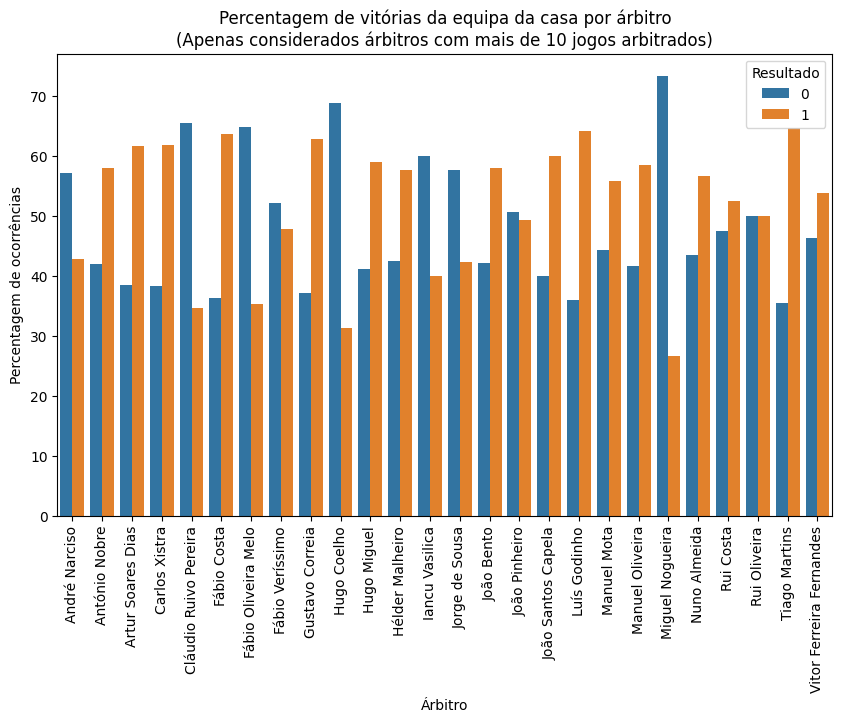

In [37]:
import matplotlib.pyplot as plt

# Calcular a contagem de ocorrências de cada valor por árbitro
# Contar o número de jogos arbitrados por árbitro
counts_arbitro = treino['Árbitro'].value_counts()

# Filtrar os árbitros com menos de 10 jogos arbitrados
arbitros_filtrados = counts_arbitro[counts_arbitro >= 10].index

# Filtrar o DataFrame original com base nos árbitros filtrados
df_filtrado = treino[treino['Árbitro'].isin(arbitros_filtrados)]

# Calcular a contagem de ocorrências de cada valor por árbitro no DataFrame filtrado
counts = df_filtrado.groupby('Árbitro')['favorito_venceu'].value_counts(normalize=True).mul(100).rename('Percentage').reset_index()

#counts = counts['fav']

# Criar o gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x='Árbitro', y='Percentage', hue='favorito_venceu', data=counts)
plt.title('Percentagem de vitórias da equipa da casa por árbitro\n(Apenas considerados árbitros com mais de 10 jogos arbitrados)')
plt.xlabel('Árbitro')
plt.ylabel('Percentagem de ocorrências')
plt.xticks(rotation=90)
plt.legend(title='Resultado')

plt.show()

In [38]:
treino[treino['Árbitro'] == 'Miguel Nogueira']['result']

639     D
685     D
712     H
741     A
784     H
925     H
965     D
980     D
1044    D
1064    D
1090    H
1115    A
1142    D
1175    H
1204    H
Name: result, dtype: category
Categories (3, object): ['H' < 'D' < 'A']

In [39]:
# Testar se há evidência estatística de que a presença do árbitro António Nobre influencia a favor da equipa da casa

nogueira = treino[treino['Árbitro'] == 'Miguel Nogueira']
nao_nogueira = treino[treino['Árbitro'] != 'Miguel Nogueira']

# -> H0: média da dif de golos com joão bento - média da dif de golos sem joão bento = 0 (A equipa da casa não tem vantagem)
# -> H1: média da dif de golos com joão bento - média da dif de golos sem joão bento > 0 (A equipa da casa tem vantagem)

test_statistic, p_value = ttest_ind(nao_nogueira['favorito_venceu'], nogueira['favorito_venceu'], alternative='greater')

# Print the test statistic and p-value
print("t-test statistic: {:.2f}".format(test_statistic))
print("p-value: {:.4f}".format(p_value))

# t-test statistic: 1.93
# p-value: 0.0269

# Como p-value < 0.05, rejeitamos H0, o que nos diz que a equipa da casa é beneficiada com a presença do árbitro João Bento

# Nota: Este árbitro foi despromovido na época 2020/21
#ta mal

t-test statistic: 2.15
p-value: 0.0160


In [40]:
# Testar se há evidência estatística de que a presença do árbitro António Nobre influencia a favor da equipa da casa

martins = treino[treino['Árbitro'] == 'Tiago Martins']
nao_martins = treino[treino['Árbitro'] != 'Tiago Martins']

# -> H0: média da dif de golos com joão bento - média da dif de golos sem joão bento = 0 (A equipa da casa não tem vantagem)
# -> H1: média da dif de golos com joão bento - média da dif de golos sem joão bento > 0 (A equipa da casa tem vantagem)

test_statistic, p_value = ttest_ind(martins['favorito_venceu'], nao_martins['favorito_venceu'], alternative='greater')

# Print the test statistic and p-value
print("t-test statistic: {:.2f}".format(test_statistic))
print("p-value: {:.4f}".format(p_value))

# t-test statistic: 1.93
# p-value: 0.0269

# Como p-value < 0.05, rejeitamos H0, o que nos diz que a equipa da casa é beneficiada com a presença do árbitro João Bento

# Nota: Este árbitro foi despromovido na época 2020/21

t-test statistic: 1.75
p-value: 0.0401


In [41]:
# Testar se há evidência estatística de que a presença do árbitro António Nobre influencia a favor da equipa da casa

hugo = treino[treino['Árbitro'] == 'Hugo Coelho']
nao_hugo = treino[treino['Árbitro'] != 'Hugo Coelho']

# -> H0: média da dif de golos com joão bento - média da dif de golos sem joão bento = 0 (A equipa da casa não tem vantagem)
# -> H1: média da dif de golos com joão bento - média da dif de golos sem joão bento > 0 (A equipa da casa tem vantagem)

test_statistic, p_value = ttest_ind(nao_hugo['favorito_venceu'], hugo['favorito_venceu'], alternative='greater')

# Print the test statistic and p-value
print("t-test statistic: {:.2f}".format(test_statistic))
print("p-value: {:.4f}".format(p_value))

# t-test statistic: 1.93
# p-value: 0.0269

# Como p-value < 0.05, rejeitamos H0, o que nos diz que a equipa da casa é beneficiada com a presença do árbitro João Bento

# Despromovido

t-test statistic: 1.85
p-value: 0.0326


In [42]:
treino[treino['Árbitro'] == 'Hugo Coelho']

,Jornada,Dia,Data,Horário,home,xG_home,xG_away,away,Assistance,Local,...,points_home_MA5,points_away_MA5,points_home_MA17,points_away_MA17,points_home_MA34,points_away_MA34,posicao_casa,posicao_fora,equipa_favorita,favorito_venceu
648,5.0,sáb,2020-10-24,15:30:00,Nacional,0.4,0.8,Pacos Ferreira,0.0,Estádio da Madeira,...,1.0,1.0,0.764706,1.588235,0.882353,1.235294,12.0,14.0,H,0
717,12.0,seg,2021-01-04,19:00:00,Gil Vicente,0.6,0.3,Belenenses,0.0,Estádio Cidade de Barcelos,...,1.4,1.0,1.294118,0.941176,1.235294,1.029412,11.0,15.0,H,0
750,16.0,seg,2021-02-01,16:00:00,Santa Clara,1.3,0.5,Belenenses,0.0,Estádio de São Miguel,...,1.0,0.8,1.176471,1.058824,1.294118,1.029412,7.0,14.0,H,1
787,20.0,dom,2021-02-21,15:00:00,Rio Ave,0.5,1.2,Famalicao,0.0,Estádio do Rio Ave Futebol Clube,...,1.4,0.2,1.176471,0.705882,1.411765,1.088235,9.0,18.0,H,0
919,1.0,sáb,2021-08-07,12:45:00,Arouca,1.0,1.8,Estoril,513.0,Estádio Municipal de Arouca,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,10.0,H,0
952,4.0,dom,2021-08-29,19:30:00,Santa Clara,1.1,0.4,Gil Vicente,588.0,Estádio de São Miguel,...,1.4,1.8,1.294118,1.529412,1.176471,1.176471,18.0,7.0,H,1
981,8.0,sex,2021-10-01,19:00:00,Maritimo,0.3,1.1,Moreirense,1872.0,Estádio dos Barreiros,...,0.6,1.0,1.176471,1.117647,1.000000,1.205882,12.0,14.0,H,0
991,9.0,sáb,2021-10-23,14:30:00,Santa Clara,1.6,2.4,Famalicao,830.0,Estádio de São Miguel,...,1.0,0.6,1.176471,1.000000,1.235294,1.000000,15.0,18.0,H,0
1042,15.0,sex,2021-12-17,18:00:00,Santa Clara,1.5,0.5,Guimaraes,636.0,Estádio de São Miguel,...,0.8,1.8,1.117647,1.352941,1.205882,1.147059,16.0,7.0,A,0
1052,16.0,ter,2021-12-28,19:00:00,Maritimo,1.8,0.9,Vizela,2468.0,Estádio dos Barreiros,...,1.4,1.0,0.882353,NaN,0.941176,NaN,11.0,13.0,A,0


In [43]:
treino['yellow_card_fav'] = treino.apply(lambda row: row['yellow_card_home'] if row['favorito_venceu'] == 1 else row['yellow_card_away'],axis=1)

In [44]:
treino['yellow_card_fav'].describe()

count    1224.000000
mean        2.604575
std         1.547454
min         0.000000
25%         1.000000
50%         3.000000
75%         4.000000
max        10.000000
Name: yellow_card_fav, dtype: float64

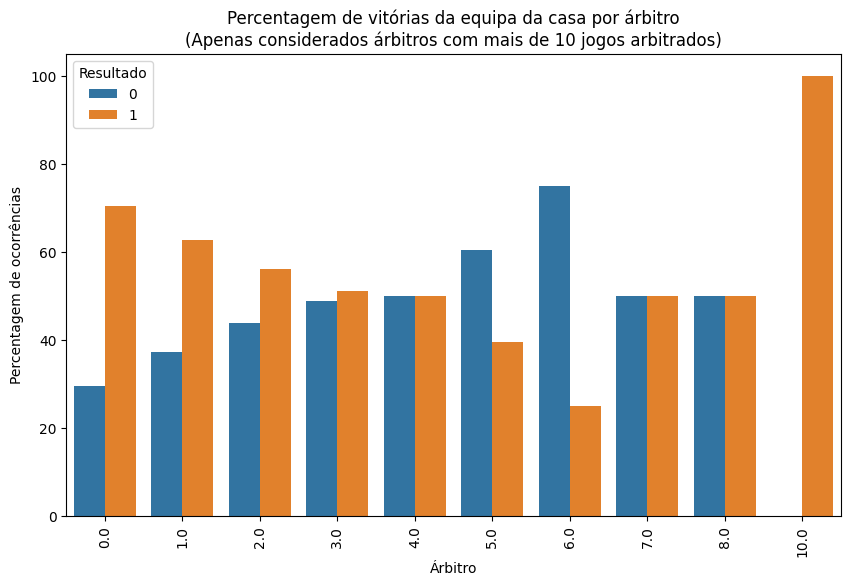

In [45]:
import matplotlib.pyplot as plt

# Calcular a contagem de ocorrências de cada valor por árbitro
# Contar o número de jogos arbitrados por árbitro
counts_arbitro = treino['yellow_card_fav'].value_counts()

# Filtrar os árbitros com menos de 10 jogos arbitrados
arbitros_filtrados = counts_arbitro.index

# Filtrar o DataFrame original com base nos árbitros filtrados
df_filtrado = treino[treino['yellow_card_fav'].isin(arbitros_filtrados)]

# Calcular a contagem de ocorrências de cada valor por árbitro no DataFrame filtrado
counts = df_filtrado.groupby('yellow_card_fav')['favorito_venceu'].value_counts(normalize=True).mul(100).rename('Percentage').reset_index()

# counts = counts[counts['result'] == 'H']

# Criar o gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x='yellow_card_fav', y='Percentage', hue='favorito_venceu', data=counts)
plt.title('Percentagem de vitórias da equipa da casa por árbitro\n(Apenas considerados árbitros com mais de 10 jogos arbitrados)')
plt.xlabel('Árbitro')
plt.ylabel('Percentagem de ocorrências')
plt.xticks(rotation=90)
plt.legend(title='Resultado')

plt.show()

In [46]:
# Testar se há evidência estatística de que a presença do árbitro António Nobre influencia a favor da equipa da casa

seisy = treino[treino['yellow_card_fav'] == 6]
nao_seisy = treino[treino['yellow_card_fav'] != 6]

# -> H0: média da dif de golos com joão bento - média da dif de golos sem joão bento = 0 (A equipa da casa não tem vantagem)
# -> H1: média da dif de golos com joão bento - média da dif de golos sem joão bento > 0 (A equipa da casa tem vantagem)

test_statistic, p_value = ttest_ind(nao_seisy['favorito_venceu'], seisy['favorito_venceu'], alternative='greater')

# Print the test statistic and p-value
print("t-test statistic: {:.2f}".format(test_statistic))
print("p-value: {:.4f}".format(p_value))

# Só precisamos de perceber se estes amarelos são depois de golos sofridos ou não

# t-test statistic: 1.93
# p-value: 0.0269

t-test statistic: 3.57
p-value: 0.0002


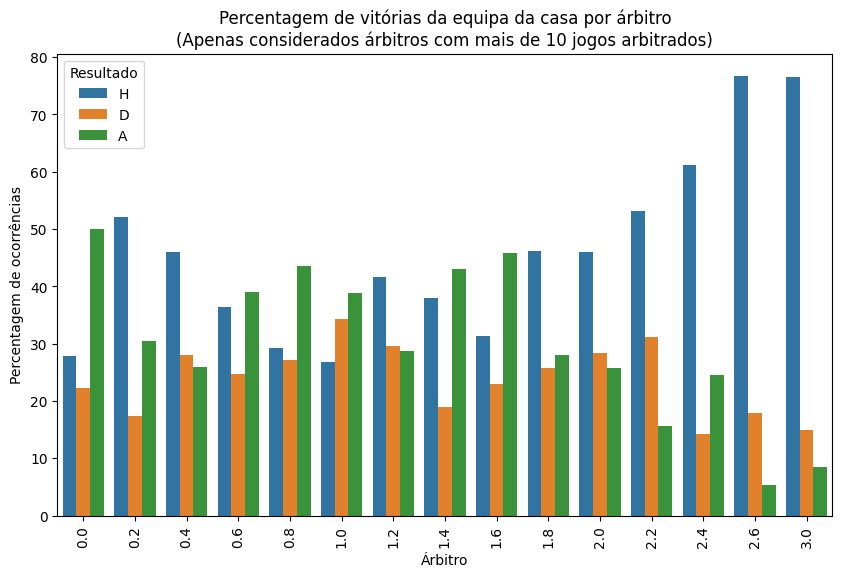

In [47]:
import matplotlib.pyplot as plt

# Calcular a contagem de ocorrências de cada valor por árbitro
# Contar o número de jogos arbitrados por árbitro
counts_arbitro = treino['points_home_MA5'].value_counts()

# Filtrar os árbitros com menos de 10 jogos arbitrados
arbitros_filtrados = counts_arbitro.index

# Filtrar o DataFrame original com base nos árbitros filtrados
df_filtrado = treino[treino['points_home_MA5'].isin(arbitros_filtrados)]

# Calcular a contagem de ocorrências de cada valor por árbitro no DataFrame filtrado
counts = df_filtrado.groupby('points_home_MA5')['result'].value_counts(normalize=True).mul(100).rename('Percentage').reset_index()

# counts = counts[counts['result'] == 'H']

# Criar o gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x='points_home_MA5', y='Percentage', hue='result', data=counts)
plt.title('Percentagem de vitórias da equipa da casa por árbitro\n(Apenas considerados árbitros com mais de 10 jogos arbitrados)')
plt.xlabel('Árbitro')
plt.ylabel('Percentagem de ocorrências')
plt.xticks(rotation=90)
plt.legend(title='Resultado')

plt.show()

In [48]:
zerodois = treino[treino['points_home_MA5'] == 0.2]
zerodois

,Jornada,Dia,Data,Horário,home,xG_home,xG_away,away,Assistance,Local,...,points_away_MA5,points_home_MA17,points_away_MA17,points_home_MA34,points_away_MA34,posicao_casa,posicao_fora,equipa_favorita,favorito_venceu,yellow_card_fav
53,6.0,seg,2018-10-01,20:15:00,Aves,1.4,1.4,Portimonense,1911.0,Estádio Clube Desportivo das Aves,...,0.8,NaN,NaN,NaN,NaN,18.0,16.0,H,1,2.0
60,7.0,dom,2018-10-07,15:00:00,Boavista,1.5,1.1,Aves,4331.0,Estádio do Bessa Século XXI,...,0.8,NaN,NaN,NaN,NaN,18.0,16.0,H,1,3.0
96,11.0,dom,2018-12-02,17:30:00,Chaves,0.6,1.8,Guimaraes,5980.0,Estádio Municipal Eng. Manuel Branco Tei...,...,1.8,NaN,NaN,NaN,NaN,18.0,8.0,A,1,1.0
107,12.0,seg,2018-12-10,20:15:00,Feirense,1.9,1.0,Maritimo,2110.0,Estádio Marcolino de Castro,...,0.0,NaN,NaN,NaN,NaN,17.0,15.0,H,0,4.0
115,13.0,dom,2018-12-16,17:30:00,Maritimo,0.3,1.7,Benfica,9830.0,Estádio dos Barreiros,...,1.8,NaN,NaN,NaN,NaN,15.0,4.0,A,1,5.0
117,14.0,sáb,2018-12-22,15:30:00,Feirense,1.8,1.5,Portimonense,2510.0,Estádio Marcolino de Castro,...,1.4,NaN,NaN,NaN,NaN,16.0,9.0,A,1,4.0
130,15.0,qua,2019-01-02,20:15:00,Rio Ave,1.6,1.3,Moreirense,2089.0,Estádio do Rio Ave Futebol Clube,...,1.8,NaN,NaN,NaN,NaN,10.0,7.0,H,0,3.0
135,16.0,sáb,2019-01-05,20:30:00,Maritimo,1.0,1.5,Portimonense,6443.0,Estádio dos Barreiros,...,2.4,NaN,NaN,NaN,NaN,17.0,7.0,H,1,4.0
146,17.0,sex,2019-01-11,19:00:00,Aves,1.2,0.8,Feirense,870.0,Estádio Clube Desportivo das Aves,...,0.6,NaN,NaN,NaN,NaN,17.0,16.0,H,0,3.0
152,17.0,dom,2019-01-13,20:00:00,Rio Ave,0.9,1.9,Setubal,2163.0,Estádio do Rio Ave Futebol Clube,...,0.2,NaN,NaN,NaN,NaN,10.0,13.0,H,0,6.0


In [49]:
# Testar se há evidência estatística de que a presença do árbitro António Nobre influencia a favor da equipa da casa

zerodois = treino[treino['points_home_MA5'] == 0.2]
nao_zerodois = treino[treino['points_home_MA5'] != 0.2]

# -> H0: média da dif de golos com joão bento - média da dif de golos sem joão bento = 0 (A equipa da casa não tem vantagem)
# -> H1: média da dif de golos com joão bento - média da dif de golos sem joão bento > 0 (A equipa da casa tem vantagem)

test_statistic, p_value = ttest_ind(zerodois['dif'], nao_zerodois['dif'], alternative='greater')

# Print the test statistic and p-value
print("t-test statistic: {:.2f}".format(test_statistic))
print("p-value: {:.4f}".format(p_value))

# Só precisamos de perceber se estes amarelos são depois de golos sofridos ou não

# t-test statistic: 1.93
# p-value: 0.0269

t-test statistic: 0.91
p-value: 0.1811


In [54]:
treino.to_csv('final.csv')